# Scattershot Boson Sampling

Implementation of Scattershot Boson Sampling [\[1\]](https://arxiv.org/abs/1305.4346) [\[2\]](https://www.scottaaronson.com/blog/?p=1579) in Strawberry Fields.

As we have seen in the Boson Sampling (BS) tutorial, a boson sampler is a quantum machine that takes a deterministic input made of $m$ modes, $n$ of them sending photons simultaneously through an interferometer modeled by a unitary matrix $U$. The output of the interferometer is a random distribution of photons that can be computed classically with the permanent of $U$. 

Scattershot Boson Sampling (SBS) was motivated by the fact that emitting $n$ photons simultaneously in the input is experimentally very hard to realize for large $n$. What is simpler to build is a random input using Spontaneous Parametric Down-Conversion (SPDC), whose distribution is given by $P(k_i = k)=(1-\chi^2) \chi^{2 k}$ where $k_i$ is the number of photon in mode i and $\chi \in (-1,1)$ is a given parameter (equation (7) of the [original paper \[1\]](https://arxiv.org/abs/1305.4346)). The advantage of SPDC is not only that it's a coherent source of photons but also that it always emits an even number of photons: one that can be used in a boson sampling circuit and one to measure the input.

In quantum optics, we model SPDC by 2-mode squeezing gates $\hat{S}_2$ such that $\hat{S}_2 |0 \rangle |0 \rangle = \sqrt{(1-\chi^2)} \sum_{k=0}^{\infty} \chi^k |k \rangle |k \rangle$ (equation (3) of the paper). The first qubit will be used to measure the input while the second will be sent to the circuit. 

In SF, this 2-mode squeezing gate is called S2gate and takes as input a squeezing parameter $r$ related to $\chi$ by the formula $r=\tanh(\chi)$

In [1]:
import numpy as np
import scipy as sp
from math import factorial, tanh
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import strawberryfields as sf
from strawberryfields.ops import *

/home/artix41/miniconda3/envs/sf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Constructing the circuit

### Constants

Our circuit will depend on a few parameters. The first constants are the squeezing parameter $r \in [-1,1]$ (already described in introduction) and the cutoff number, which corresponds to the maximum number of photons per mode considered in the computation (used to make the simulation tractable).

In [3]:
r_squeezing = 0.8 # squeezing parameter for the S2gate (here taken randomly between -1 and 1)
cutoff = 7 # max number of photons computed per mode

Then comes the unitary matrix, representing the interferometer. We have decided to implement a 4-modes boson sampler, and we therefore need a $4 \times 4$-unitary matrix. Any kind of such unitary matrix could do well, but for simplicity, we choose to implement it using two rotations: one with angle $\theta_1$ for the qubits 1 and 2, and another with angle $\theta_2$ for the qubits 3 and 4. The final matrix has the form: $\begin{pmatrix} \cos(\theta_1) & - \sin(\theta_1) & 0 & 0  \\ \sin(\theta_1) & cos(\theta_1) & 0 & 0 \\ 0 & 0 & \cos(\theta_2) & - \sin(\theta_2) \\ 0 & 0 & \cos(\theta_2) & \sin(\theta_2) \end{pmatrix}$ with $\theta_1, \theta_2 \in [0,2\pi)$.

In [4]:
theta1 = 0.5
theta2 = 1

U = np.array([[np.cos(theta1), -np.sin(theta1), 0,               0             ],
              [np.sin(theta1),  np.cos(theta1), 0,               0             ],
              [0,               0,              np.cos(theta2), -np.sin(theta2)],
              [0,               0,              np.sin(theta2),  np.cos(theta2)]])

### Circuit

We instantiate our circuit with 8 qubits, 4 for the input, 4 for the output.

In [5]:
eng, q = sf.Engine(8)

We can then declare our circuit. The first four lines are 2-modes squeezing gates, which generate a random number of photons  

In [6]:
with eng:
    S2gate(r_squeezing) | (q[0], q[4])
    S2gate(r_squeezing) | (q[1], q[5])
    S2gate(r_squeezing) | (q[2], q[6])
    S2gate(r_squeezing) | (q[3], q[7])

    Interferometer(U) | (q[4], q[5], q[6], q[7])

### Running

Run the simulation up to 'cutoff' photons per mode

In [7]:
state = eng.run('fock', cutoff_dim=cutoff)

Get the probability associated to each state

In [8]:
probs = state.all_fock_probs()

Reshape 'probs' such that probs $[m_1, \dots, m_4,n_1, \dots, n_4]$ gives the probability of the having jointly the input state $(m_1, \dots, m_4)$ (with $m_i$ the number of photons in input mode $i$) and the output state $(n_1, \dots, n_4)$ (with $n_i$ the number of photons in output mode $i$)

In [9]:
probs = probs.reshape(*[cutoff]*8)

The sum is not 1 because of the finite cutoff:

In [10]:
np.sum(probs)

0.89124899676917

## Analysis

The goal of this section is to compare the simulated probability with the theoretical one. 

### Computation of the theoretical probability

To do so, the first step is to compute the theoretical probability $P(\textrm{input}=(m_1, m_2, m_3, m_4), \textrm{output}=(n_1, n_2, n_3, n_4))$, where $m_i,n_i \in \mathbb{N}$ represent the number of photons respectively in input and output modes $i$.   Using the definition of conditional probability, we can decompose it as:

\\[
P(\textrm{input}, \textrm{output}) = P(\textrm{output} \mid \textrm{input}) P(\textrm{input}) 
\\]

The value of $P(\textrm{output} \mid \textrm{input})$ is given in the [Boson Sampling tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial):

\\[
P(\textrm{input}=(m_1, m_2, m_3, m_4) \mid \textrm{output}=(n_1, n_2, n_3, n_4)) = \frac{\left| \textrm{Perm}(U_{st}) \right| ^2}{n_1! n_2! n_3! n_4! m_1! m_2! m_3! m_4!}
\\]

while $P(\textrm{input})$ depends on the SPDC properties (see introduction) and can be computed in the following way:


\\[
\begin{equation}
\begin{split}
P(\textrm{input} =(m_1, m_2, m_3, m_4)) &= \prod_{i=1}^4 P(m_i) \\
 & = \prod_{i=1}^4 (1-\chi^2) \chi^{2m_i} \\
 & = (1-\chi^2)^4 \chi^{2 \sum m_i} \\
 & = (1-\chi^2)^m \chi^{2 n}
\end{split}
\end{equation}
\\]

with $m$ the number of modes (here 4) and $n=\sum m_i$ the total number of photons. The value of $P(m_i)$ is directly taken from the original paper (equation (7)).

Using that, we can now perform the computation.

First, the permanent of the matrix (code from the [BS tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial)): 

In [11]:
def perm(M):
    n_output = M.shape[0]
    n_input = M.shape[1]
    if n_output != n_input: # if non-conservation of photon number
        return 0
    n = n_input
    if n == 0:
        return 1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]    
    
    return p/2**(n-1)

Then the probability of the output given an input. For that, we use the algorithm given in section V of [\[3\]](https://arxiv.org/pdf/1212.2240.pdf) to compute the matrix $U_{st}$ (called $U_{I,O}$ in the cited paper). To sum it up, it consists in extracting $m_j$ times the column $j$ of $U$ for every $j$, and $n_i$ times the row $i$ of $U$ for every $i$ (with $m_j$ and $n_i$ still representing the number of photons respectively in input $j$ and output $i$).

In [12]:
def get_proba_output(U, input, output):
    # The two lines below are the extracted row and column indices.
    # For instance, for output=[3,2,1,0], we want list_rows=[0,0,0,1,1,2].
    # sum(.,[]) is a Python trick to flatten the list
    list_rows = sum([[i] * output[i] for i in range(len(output))],[])
    list_columns = sum([[i] * input[i] for i in range(len(input))],[])
    
    U_st = U[:,list_columns][list_rows,:]
    perm_squared = np.abs(perm(U_st))**2
    denominator = np.prod([factorial(inp) for inp in input]) * np.prod([factorial(out) for out in output])
    return perm_squared / denominator

In [13]:
def get_proba_input(input):
    chi = np.tanh(r_squeezing)
    n = np.sum(input)
    m = len(input)
    return (1 - chi**2)**m * chi**(2*n)

In [14]:
def get_proba(U, result):
    input, output = result[0:4], result[4:8]
    return get_proba_output(U, input, output) * get_proba_input(input) # P(O,I) = P(O|I) P(I)

### Comparison between theory and simulation

In [15]:
print("Theory: \t", get_proba(U, [0,0,0,0,0,0,0,0]))
print("Simulation: \t", probs[0,0,0,0,0,0,0,0])

Theory: 	 0.09768292717671037
Simulation: 	 0.09768292717671045


In [16]:
print("Theory: \t", get_proba(U, [1,0,0,0,1,0,0,0]))
print("Simulation: \t", probs[1,0,0,0,1,0,0,0])

Theory: 	 0.03317255267067434
Simulation: 	 0.03317255267067434


In [17]:
print("Theory: \t", get_proba(U, [1,0,0,0,0,1,0,0]))
print("Simulation: \t", probs[1,0,0,0,0,1,0,0])

Theory: 	 0.009900229268683655
Simulation: 	 0.009900229268683657


We see that the results are very similar

## Visualization

To visualize the results and the effect of a scattershot boson sampler, we will draw some examples of sampling.

### Make the probabilities sum to 1
Due to computational issues, the sum of the probability does not equal 1. Since it prevents us from sampling correctly, we choose to add the missing weight to the outcome [0,0,0,0, 0,0,0,0]

In [18]:
probs[0,0,0,0, 0,0,0,0] += 1 - np.sum(probs)

In [19]:
np.sum(probs)

1.0000000000000002

### Sample

Get all possible choices as a list of outcomes $ [ m_1, m_2, m_3, m_4, n_1, n_2, n_3, n_4 ] $

In [20]:
list_choices = list(itertools.product(*[range(cutoff)]*8))
list_choices[0]

(0, 0, 0, 0, 0, 0, 0, 0)

Get the probability of each choice index

In [21]:
list_probs = [probs[list_choices[i]] for i in range(len(list_choices))]
list_probs[0]

0.20643393040754043

Sample a choice using this probability distribution

In [22]:
choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]
choice

(1, 1, 0, 0, 2, 0, 0, 0)

### Visualize

#### Constants

In [114]:
## Colors
color_interf = colormap[0]
color_lines = "black"
color_laser = colormap[3]
color_photons = "#F5D76E"
color_spdc = colormap[4]
color_meas = colormap[1]

color_text_interf = "white"
color_text_spdc = "white"
color_text_measure = "white"

## Sizes
unit = 0.05
radius_photons = 0.015
margin_photons = 0.01
margin_input_meas = 1*unit # space between the end of the input measure and the interferometer 

width_laser = 8*unit
width_spdc = 2*unit
width_lines_spdc = 1*unit
width_line_interf = 8*unit
width_measure = 2*unit
width_line_input = width_line_interf - margin_input_meas - width_measure
width_interf = 8*unit
width_line_output = 6*unit

height_interf = 20*unit
height_spdc = 2*unit

## Positions
x_begin_laser = -0.5
x_begin_spdc = x_begin_laser + width_laser
x_end_spdc = x_begin_spdc + width_spdc
x_begin_lines_spdc = x_end_spdc
x_end_lines_spdc = x_end_spdc + width_lines_spdc
x_end_line_input = x_end_lines_spdc + width_line_input
x_begin_input_meas = x_end_line_input
x_end_input_meas = x_begin_input_meas + width_measure
x_begin_interf = x_end_lines_spdc + width_line_interf
x_end_interf = x_begin_interf + width_interf
x_end_line_output = x_end_interf + width_line_output
x_end_output_meas = x_end_line_output + width_measure

y_begin_interf = 0
sep_lines_interf = height_interf / 5
sep_lines_spdc = 2*unit

#### Plot

(-0.5875, 1.3375000000000004, -0.05, 1.05)

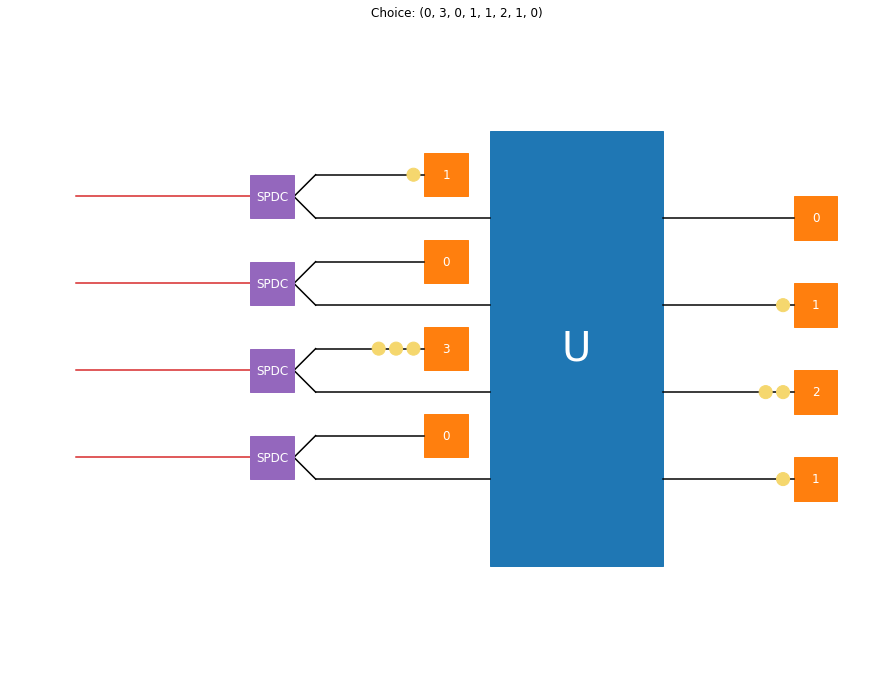

In [161]:
# Sampling

choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

# Plot

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
fig.axis = "equal"

interf = mpatches.Rectangle((x_begin_interf,0),width_interf, height_interf, 
                            edgecolor=color_interf,facecolor=color_interf)
ax.add_patch(interf)

plt.text(x_begin_interf+width_interf/2, y_begin_interf+height_interf/2, 'U',
         {'ha': 'center', 'va': 'center'}, size=40, color=color_text_interf)

for i_line in range(4):
    y_line_interf = y_begin_interf + (i_line+1) * sep_lines_interf 
    y_line_input = y_line_interf + sep_lines_spdc
    y_line_laser = y_line_interf + (y_line_input - y_line_interf) / 2
    
    # draw laser lines
    plt.plot([x_begin_laser,x_begin_spdc], [y_line_laser,y_line_laser], color=color_laser)
    
    # draw lines for the output of the SPDC
    plt.plot([x_begin_lines_spdc,x_end_lines_spdc], [y_line_laser,y_line_interf], color=color_lines)
    plt.plot([x_begin_lines_spdc,x_end_lines_spdc], [y_line_laser,y_line_input], color=color_lines)
    
    # draw lines interferometer lines
    plt.plot([x_end_lines_spdc,x_begin_interf], [y_line_interf,y_line_interf], color=color_lines)
    plt.plot([x_end_interf, x_end_line_output], [y_line_interf,y_line_interf], color=color_lines)
    
    # draw lines for the input photons (before measure)
    plt.plot([x_end_lines_spdc,x_end_line_input], [y_line_input,y_line_input], color=color_lines)
    
    # draw the input measures
    input_meas = mpatches.Rectangle((x_begin_input_meas, y_line_input-width_measure/2),width_measure,width_measure,
                                    edgecolor=color_meas,facecolor=color_meas)
    plt.text(x_begin_input_meas+width_measure/2, y_line_input, str(choice[i_line]),
             {'ha': 'center', 'va': 'center'}, size=12, color=color_text_measure)
    ax.add_patch(input_meas)
    
    # draw the output measures
    input_meas = mpatches.Rectangle((x_end_line_output, y_line_interf-width_measure/2),width_measure,width_measure,
                                    edgecolor=color_meas,facecolor=color_meas)
    plt.text(x_end_line_output+width_measure/2, y_line_interf, str(choice[4+i_line]),
             {'ha': 'center', 'va': 'center'}, size=12, color=color_text_measure)
    ax.add_patch(input_meas)
    
    # draw the SPDC
    spdc = mpatches.Rectangle((x_begin_spdc,y_line_interf),width_spdc,height_spdc,
                              edgecolor=color_spdc,facecolor=color_spdc, zorder=3)
    plt.text(x_begin_spdc+width_spdc/2, y_line_interf+height_spdc/2, 'SPDC',
             {'ha': 'center', 'va': 'center'}, size=12, color=color_text_spdc)
    ax.add_patch(spdc)

    # draw the input photons
    for i_photon in range(choice[i_line]):
        x_photon = x_end_line_input - margin_photons - radius_photons - i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line_input], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
    
    # draw the output photons
    for i_photon in range(choice[4 + i_line]):
        x_photon = x_end_line_output - margin_photons - radius_photons - i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line_interf], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
        
plt.title("Choice: {}".format(choice))
plt.axis('equal')
plt.axis('off')

This figure represents a exemple of sampling (each time you execute the cell, it samples a new state). 

At time 0, a laser hits the 4 SPDC, which produce in consequence $n$ pairs of photons. For each pair, one photon is sent to a measuring device (for the input) and the other to the interferometer. This interferometer then outputs those $n$ photons, but in different modes (different lines in the figure), following the probability distribution described above. A measuring device finally captures those output photons.

A state consists in both the input photons (produced by the SPDC) and the output ones.

### Animation

In [183]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"

step_photon_move = 0.02
time_before_output = 1
time_laser = 7
time_begin_laser = 3

# Sampling

# choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

# Plot

fig = plt.figure()
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
fig.set_size_inches(15, 12)

interf = mpatches.Rectangle((x_begin_interf,0),width_interf, height_interf, 
                            edgecolor=color_interf,facecolor=color_interf, zorder=5)
ax.add_patch(interf)

plt.text(x_begin_interf+width_interf/2, y_begin_interf+height_interf/2, 'U',
         {'ha': 'center', 'va': 'center'}, size=40, color=color_text_interf, zorder=6)

text_input_meas = []
text_output_meas = []
photons_input = []
photons_interf = []
laser_lines = []
for i_line in range(4):
    y_line_interf = y_begin_interf + (i_line+1) * sep_lines_interf 
    y_line_input = y_line_interf + sep_lines_spdc
    y_line_laser = y_line_interf + (y_line_input - y_line_interf) / 2
    
    # draw laser lines
    laser_lines.append(plt.plot([x_begin_laser,x_begin_spdc], [y_line_laser,y_line_laser], color=color_laser, linewidth=1)[0])
    
    # draw lines for the output of the SPDC
    plt.plot([x_begin_lines_spdc,x_end_lines_spdc], [y_line_laser,y_line_interf], color=color_lines)
    plt.plot([x_begin_lines_spdc,x_end_lines_spdc], [y_line_laser,y_line_input], color=color_lines)
    
    # draw lines interferometer lines
    plt.plot([x_end_lines_spdc,x_begin_interf], [y_line_interf,y_line_interf], color=color_lines)
    plt.plot([x_end_interf, x_end_line_output], [y_line_interf,y_line_interf], color=color_lines)
    
    # draw lines for the input photons (before measure)
    plt.plot([x_end_lines_spdc,x_end_line_input], [y_line_input,y_line_input], color=color_lines)
    
    # draw the input measures
    input_meas = mpatches.Rectangle((x_begin_input_meas, y_line_input-width_measure/2),width_measure,width_measure,
                                    edgecolor=color_meas,facecolor=color_meas, zorder=4)
    text_input_meas.append(plt.text(x_begin_input_meas+width_measure/2, y_line_input, '0',
                                    {'ha': 'center', 'va': 'center'}, size=15, color=color_text_measure, zorder=5))
    ax.add_patch(input_meas)
    
    # draw the output measures
    output_meas = mpatches.Rectangle((x_end_line_output, y_line_interf-width_measure/2),width_measure,width_measure,
                                    edgecolor=color_meas,facecolor=color_meas, zorder=4)
    text_output_meas.append(plt.text(x_end_line_output+width_measure/2, y_line_interf, '0',
                                     {'ha': 'center', 'va': 'center'}, size=15, color=color_text_measure, zorder=5))
    ax.add_patch(output_meas)
    
    # draw the SPDC
    spdc = mpatches.Rectangle((x_begin_spdc,y_line_interf),width_spdc,height_spdc,
                              edgecolor=color_spdc,facecolor=color_spdc, zorder=3)
    plt.text(x_begin_spdc+width_spdc/2, y_line_interf+height_spdc/2, 'SPDC',
             {'ha': 'center', 'va': 'center'}, size=12, color=color_text_spdc)
    ax.add_patch(spdc)
    
    # draw the input photons
    for i_photon in range(choice[i_line]):
        x_photon = x_end_lines_spdc + radius_photons + i_photon*(radius_photons*2 + margin_photons)
        photons_input.append(mpatches.Circle([x_photon,y_line_input], radius_photons, color=color_photons, alpha=0, zorder=3))

    # draw the output photons
    for i_photon in range(choice[i_line]):
        x_photon = x_end_lines_spdc + radius_photons + i_photon*(radius_photons*2 + margin_photons)
        photons_interf.append(mpatches.Circle([x_photon,y_line_interf], radius_photons, color=color_photons, alpha=0, zorder=3))
    
nb_photons = np.sum(choice[0:4])
counter_after_interf = 0
nb_photons_in_input_meas = 0
nb_photons_in_output_meas = 0
nb_photons_in_interf = 0
end_animation = False
        
def init():
    for photon in photons_input:
        ax.add_patch(photon)
    for photon in photons_interf:
        ax.add_patch(photon)
    return photons_input + photons_interf + text_input_meas + text_output_meas

def animate(t):
    global nb_photons_in_input_meas, nb_photons_in_output_meas, nb_photons_in_interf, counter_after_interf, end_animation
                
    if t < time_begin_laser or end_animation:
        return []
    elif t == time_begin_laser:
        for mode in range(4):
            laser_lines[mode].set_linewidth(4)
        return laser_lines
    elif time_begin_laser < t < time_begin_laser + time_laser:
        return []
    elif t == time_begin_laser + time_laser:
        for mode in range(4):
            laser_lines[mode].set_linewidth(1)
            for photon in photons_interf:
                photon.set_alpha(1)
            for photon in photons_input:
                photon.set_alpha(1)
        return photons_input + photons_interf + laser_lines

    if nb_photons_in_input_meas < nb_photons:
        for photon in photons_input:
            x,y = photon.center
            if x < x_begin_input_meas + 2*radius_photons:
                photon.center = (x + step_photon_move, y)
            else:
                nb_photons_in_input_meas += 1
    else:
        for i_mode in range(4):
            text_input_meas[i_mode].set_text(str(choice[i_mode]))
            
    if nb_photons_in_interf < nb_photons:
        for photon in photons_interf:
            x,y = photon.center
            if x < x_begin_interf + 2*radius_photons:
                photon.center = (x + step_photon_move, y)
            else:
                nb_photons_in_interf += 1
    else:
        counter_after_interf += 1
            
    if counter_after_interf == time_before_output:
        i = 0
        for i_line in range(4):
            y_line_interf = y_begin_interf + (i_line+1) * sep_lines_interf 
            for i_photon in range(choice[4 + i_line]):
                x_photon = x_end_interf - radius_photons - i_photon*(radius_photons*2 + margin_photons)
                photons_interf[i].center = (x_photon, y_line_interf)
                i+=1
                
    if counter_after_interf > time_before_output:
        if nb_photons_in_output_meas < nb_photons:
            for photon in photons_interf:
                x,y = photon.center
                if x < x_end_line_output + radius_photons*2:
                    photon.center = (x + step_photon_move, y)
                else:
                    nb_photons_in_output_meas += 1
        else:
            for i_mode in range(4):
                text_output_meas[i_mode].set_text(str(choice[4+i_mode]))
            end_animation = True

    return photons_input + photons_interf + text_input_meas + text_output_meas

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=60, interval=100, blit=True)
plt.close()

anim

# References

[1] A. P. Lund, A. Laing, S. Rahimi-Keshari, T. Rudolph, J. L O'Brien and T. C. Ralph. Boson Sampling from Gaussian States. *Physical Review Letter,. [doi:10.1103/PhysRevLett.113.100502](https://link.aps.org/doi/10.1103/PhysRevLett.113.100502)*

[2] Scott Aaronson. Scattershot Boson Sampling: A new approach to scalable Boson Sampling experiments. [Blog article](https://www.scottaaronson.com/blog/?p=1579)

[3] Max Tillmann, Borivoje Dakić, René Heilmann, Stefan Nolte, Alexander Szameit, Philip Walther. Experimental Boson Sampling. *Nature Photonics [doi:10.1038/nphoton.2013.102](https://www.nature.com/articles/nphoton.2013.102)*